# Neural Networks Workshop
**CMSC 173 - Machine Learning**

---

## Learning Objectives
By the end of this workshop, you will be able to:
1. Build and train neural networks from scratch
2. Understand forward and backward propagation
3. Implement different activation functions
4. Apply regularization techniques
5. Evaluate neural network performance

---

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for consistent figures
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Setup complete! Ready to build neural networks.")

✅ Setup complete! Ready to build neural networks.


## Part 1: Understanding Activation Functions

Let's start by implementing and visualizing different activation functions.

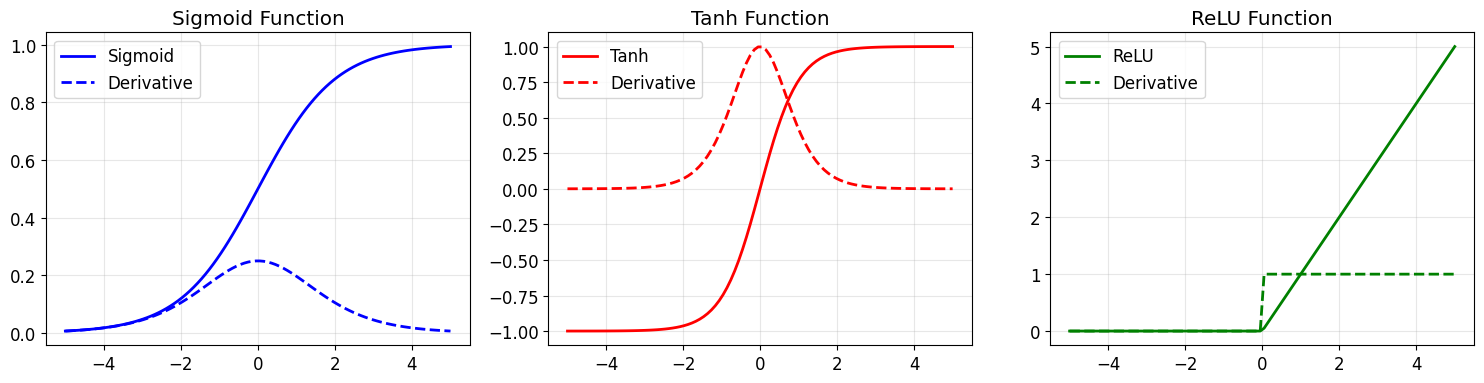

In [2]:
class ActivationFunctions:
    """Collection of activation functions and their derivatives"""
    
    @staticmethod
    def sigmoid(x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to prevent overflow
    
    @staticmethod
    def sigmoid_derivative(x):
        """Derivative of sigmoid function"""
        s = ActivationFunctions.sigmoid(x)
        return s * (1 - s)
    
    @staticmethod
    def tanh(x):
        """Hyperbolic tangent activation function"""
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x):
        """Derivative of tanh function"""
        return 1 - np.tanh(x)**2
    
    @staticmethod
    def relu(x):
        """ReLU activation function"""
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x):
        """Derivative of ReLU function"""
        return (x > 0).astype(float)

# Test the activation functions
x = np.linspace(-5, 5, 100)
activations = ActivationFunctions()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Sigmoid
axes[0].plot(x, activations.sigmoid(x), 'b-', linewidth=2, label='Sigmoid')
axes[0].plot(x, activations.sigmoid_derivative(x), 'b--', linewidth=2, label='Derivative')
axes[0].set_title('Sigmoid Function')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Tanh
axes[1].plot(x, activations.tanh(x), 'r-', linewidth=2, label='Tanh')
axes[1].plot(x, activations.tanh_derivative(x), 'r--', linewidth=2, label='Derivative')
axes[1].set_title('Tanh Function')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# ReLU
axes[2].plot(x, activations.relu(x), 'g-', linewidth=2, label='ReLU')
axes[2].plot(x, activations.relu_derivative(x), 'g--', linewidth=2, label='Derivative')
axes[2].set_title('ReLU Function')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

### 🤔 Discussion Questions
1. Which activation function has the problem of vanishing gradients?
2. Why is ReLU popular in deep networks?
3. What are the output ranges of each activation function?

## Part 2: Building a Neural Network from Scratch

Now let's implement a simple neural network class with forward and backward propagation.

In [3]:
class SimpleNeuralNetwork:
    """A simple 2-layer neural network implementation"""
    
    def __init__(self, input_size, hidden_size, output_size, activation='sigmoid'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.5
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.5
        self.b2 = np.zeros((1, self.output_size))
        
        # Set activation function
        self.activations = ActivationFunctions()
        if activation == 'sigmoid':
            self.activation = self.activations.sigmoid
            self.activation_derivative = self.activations.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = self.activations.tanh
            self.activation_derivative = self.activations.tanh_derivative
        elif activation == 'relu':
            self.activation = self.activations.relu
            self.activation_derivative = self.activations.relu_derivative
    
    def forward(self, X):
        """Forward propagation"""
        # Hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation(self.z1)
        
        # Output layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.activations.sigmoid(self.z2)  # Always sigmoid for output
        
        return self.a2
    
    def backward(self, X, y, output):
        """Backward propagation"""
        m = X.shape[0]
        
        # Calculate gradients for output layer
        dz2 = output - y
        dW2 = (1/m) * np.dot(self.a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        # Calculate gradients for hidden layer
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.activation_derivative(self.z1)
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2
    
    def update_parameters(self, dW1, db1, dW2, db2, learning_rate):
        """Update weights and biases"""
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
    
    def compute_loss(self, y_true, y_pred):
        """Compute binary cross-entropy loss"""
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)  # Prevent log(0)
        loss = -(1/m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def train(self, X, y, epochs, learning_rate):
        """Train the neural network"""
        losses = []
        
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward(X)
            
            # Compute loss
            loss = self.compute_loss(y, output)
            losses.append(loss)
            
            # Backward propagation
            dW1, db1, dW2, db2 = self.backward(X, y, output)
            
            # Update parameters
            self.update_parameters(dW1, db1, dW2, db2, learning_rate)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        
        return losses
    
    def predict(self, X):
        """Make predictions"""
        output = self.forward(X)
        return (output > 0.5).astype(int)

print("✅ Neural Network class implemented!")

✅ Neural Network class implemented!


## Part 3: Training on a Real Dataset

Let's test our neural network on a binary classification problem.

Training data shape: (700, 2)
Training labels shape: (700, 1)
Test data shape: (300, 2)
Test labels shape: (300, 1)


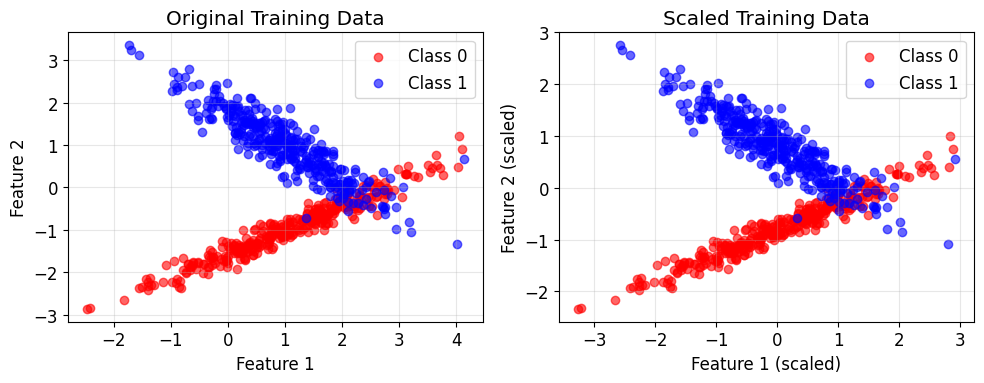

In [4]:
# Generate a binary classification dataset
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                          n_informative=2, random_state=42, n_clusters_per_class=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape y for our network
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Test labels shape: {y_test.shape}")

# Visualize the dataset
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train.flatten() == 0, 0], X_train[y_train.flatten() == 0, 1], 
           c='red', alpha=0.6, label='Class 0')
plt.scatter(X_train[y_train.flatten() == 1, 0], X_train[y_train.flatten() == 1, 1], 
           c='blue', alpha=0.6, label='Class 1')
plt.title('Original Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_train_scaled[y_train.flatten() == 0, 0], X_train_scaled[y_train.flatten() == 0, 1], 
           c='red', alpha=0.6, label='Class 0')
plt.scatter(X_train_scaled[y_train.flatten() == 1, 0], X_train_scaled[y_train.flatten() == 1, 1], 
           c='blue', alpha=0.6, label='Class 1')
plt.title('Scaled Training Data')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🚀 Student Activity (15 minutes)

**Your Task:** Compare different activation functions and hidden layer sizes.

1. Train three neural networks with different activation functions:
   - Sigmoid
   - Tanh
   - ReLU

2. For each network:
   - Use 5 hidden units
   - Train for 500 epochs
   - Learning rate = 0.1
   - Record the final loss and accuracy

3. Answer the discussion questions below

**Starter Code:**

In [5]:
# TODO: Complete this activity
activations_to_test = ['sigmoid', 'tanh', 'relu']
results = {}

for activation in activations_to_test:
    print(f"\n{'='*50}")
    print(f"Training with {activation.upper()} activation")
    print(f"{'='*50}")
    
    # TODO: Create and train the network
    # network = SimpleNeuralNetwork(input_size=?, hidden_size=?, output_size=?, activation=?)
    # losses = network.train(?, ?, epochs=?, learning_rate=?)
    
    # TODO: Make predictions and calculate accuracy
    # predictions = network.predict(?)
    # accuracy = np.mean(predictions == y_test)
    
    # TODO: Store results
    # results[activation] = {
    #     'final_loss': losses[-1],
    #     'accuracy': accuracy,
    #     'losses': losses
    # }
    
    pass  # Remove this when you implement the code

# TODO: Print comparison
print("\n" + "="*60)
print("RESULTS COMPARISON")
print("="*60)
# for activation, result in results.items():
#     print(f"{activation.upper():>10}: Loss = {result['final_loss']:.4f}, Accuracy = {result['accuracy']:.4f}")


Training with SIGMOID activation

Training with TANH activation

Training with RELU activation

RESULTS COMPARISON


### 🤔 Discussion Questions for Activity
1. Which activation function performed best? Why do you think that is?
2. Did any activation function fail to converge? If so, why?
3. How do the loss curves differ between activation functions?
4. What happens if you increase the hidden layer size to 20? Try it!

---
## Solutions to Student Activity

*Scroll down to see the solutions after attempting the activity.*

<br><br><br><br><br><br><br><br><br><br>


Training with SIGMOID activation
Epoch 0, Loss: 0.8398
Epoch 100, Loss: 0.5121
Epoch 200, Loss: 0.3650
Epoch 300, Loss: 0.2927
Epoch 400, Loss: 0.2588

Training with TANH activation
Epoch 0, Loss: 0.6157
Epoch 100, Loss: 0.2481
Epoch 200, Loss: 0.2146
Epoch 300, Loss: 0.2024
Epoch 400, Loss: 0.1933

Training with RELU activation
Epoch 0, Loss: 0.7106
Epoch 100, Loss: 0.3440
Epoch 200, Loss: 0.2634


Epoch 300, Loss: 0.2299
Epoch 400, Loss: 0.2116


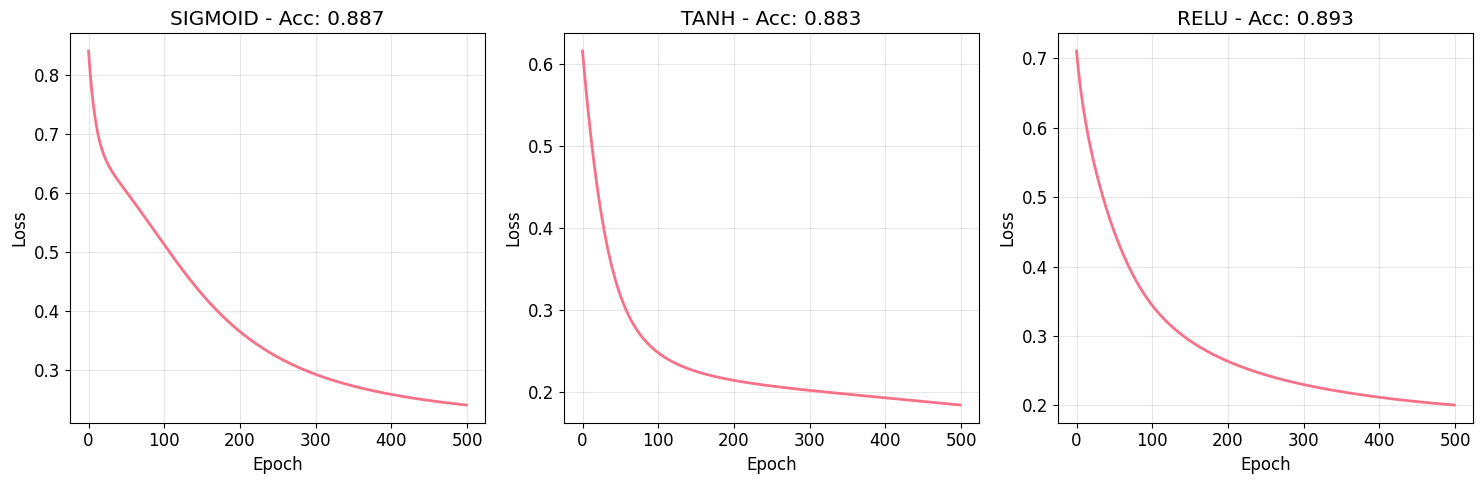


RESULTS COMPARISON
   SIGMOID: Loss = 0.2409, Accuracy = 0.8867
      TANH: Loss = 0.1845, Accuracy = 0.8833
      RELU: Loss = 0.2004, Accuracy = 0.8933

🏆 Best performing activation: RELU


In [6]:
# SOLUTION: Student Activity
activations_to_test = ['sigmoid', 'tanh', 'relu']
results = {}

plt.figure(figsize=(15, 5))

for i, activation in enumerate(activations_to_test):
    print(f"\n{'='*50}")
    print(f"Training with {activation.upper()} activation")
    print(f"{'='*50}")
    
    # Create and train the network
    network = SimpleNeuralNetwork(input_size=2, hidden_size=5, output_size=1, activation=activation)
    losses = network.train(X_train_scaled, y_train, epochs=500, learning_rate=0.1)
    
    # Make predictions and calculate accuracy
    predictions = network.predict(X_test_scaled)
    accuracy = np.mean(predictions == y_test)
    
    # Store results
    results[activation] = {
        'final_loss': losses[-1],
        'accuracy': accuracy,
        'losses': losses
    }
    
    # Plot loss curves
    plt.subplot(1, 3, i+1)
    plt.plot(losses, linewidth=2)
    plt.title(f'{activation.upper()} - Acc: {accuracy:.3f}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print("\n" + "="*60)
print("RESULTS COMPARISON")
print("="*60)
for activation, result in results.items():
    print(f"{activation.upper():>10}: Loss = {result['final_loss']:.4f}, Accuracy = {result['accuracy']:.4f}")

# Find best performing activation
best_activation = max(results.keys(), key=lambda k: results[k]['accuracy'])
print(f"\n🏆 Best performing activation: {best_activation.upper()}")

## Part 4: Regularization Techniques

Let's implement dropout regularization to prevent overfitting.

In [7]:
class RegularizedNeuralNetwork(SimpleNeuralNetwork):
    """Neural Network with regularization techniques"""
    
    def __init__(self, input_size, hidden_size, output_size, activation='relu', 
                 dropout_rate=0.0, l2_lambda=0.0):
        super().__init__(input_size, hidden_size, output_size, activation)
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
    
    def forward(self, X, training=True):
        """Forward propagation with dropout"""
        # Hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation(self.z1)
        
        # Apply dropout during training
        if training and self.dropout_rate > 0:
            self.dropout_mask = np.random.binomial(1, 1-self.dropout_rate, size=self.a1.shape) / (1-self.dropout_rate)
            self.a1 *= self.dropout_mask
        
        # Output layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.activations.sigmoid(self.z2)
        
        return self.a2
    
    def compute_loss(self, y_true, y_pred):
        """Compute loss with L2 regularization"""
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)
        
        # Cross-entropy loss
        ce_loss = -(1/m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # L2 regularization
        l2_loss = self.l2_lambda * (np.sum(self.W1**2) + np.sum(self.W2**2)) / (2*m)
        
        return ce_loss + l2_loss
    
    def backward(self, X, y, output):
        """Backward propagation with L2 regularization"""
        m = X.shape[0]
        
        # Calculate gradients for output layer
        dz2 = output - y
        dW2 = (1/m) * np.dot(self.a1.T, dz2) + (self.l2_lambda/m) * self.W2
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
        
        # Calculate gradients for hidden layer
        da1 = np.dot(dz2, self.W2.T)
        
        # Apply dropout mask to gradients
        if hasattr(self, 'dropout_mask'):
            da1 *= self.dropout_mask
        
        dz1 = da1 * self.activation_derivative(self.z1)
        dW1 = (1/m) * np.dot(X.T, dz1) + (self.l2_lambda/m) * self.W1
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2
    
    def predict(self, X):
        """Make predictions (no dropout during inference)"""
        output = self.forward(X, training=False)
        return (output > 0.5).astype(int)

print("✅ Regularized Neural Network implemented!")

✅ Regularized Neural Network implemented!


## Part 5: Comparing Regularization Effects

Let's create a more complex dataset and compare different regularization strategies.

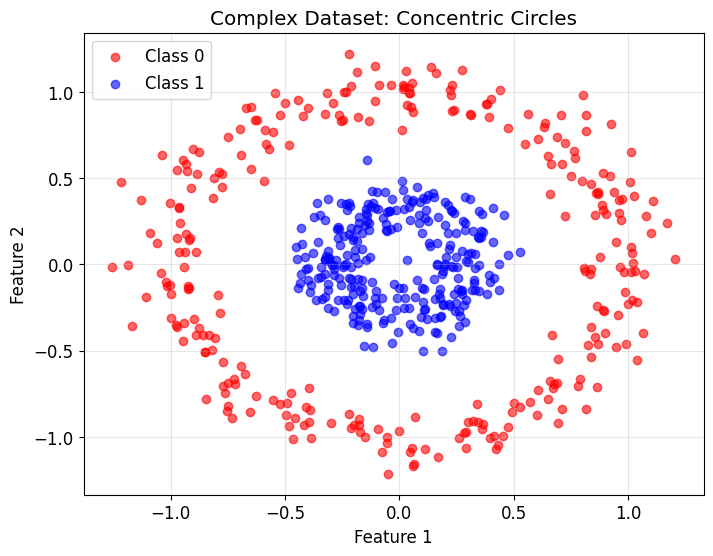

Complex dataset shape: (560, 2)


In [8]:
# Create a more complex dataset that's prone to overfitting
X_complex, y_complex = make_circles(n_samples=800, noise=0.1, factor=0.3, random_state=42)

# Split the data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_complex, y_complex, test_size=0.3, random_state=42)

# Standardize
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

# Reshape y
y_train_c = y_train_c.reshape(-1, 1)
y_test_c = y_test_c.reshape(-1, 1)

# Visualize the complex dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_train_c[y_train_c.flatten() == 0, 0], X_train_c[y_train_c.flatten() == 0, 1], 
           c='red', alpha=0.6, label='Class 0')
plt.scatter(X_train_c[y_train_c.flatten() == 1, 0], X_train_c[y_train_c.flatten() == 1, 1], 
           c='blue', alpha=0.6, label='Class 1')
plt.title('Complex Dataset: Concentric Circles')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Complex dataset shape: {X_train_c_scaled.shape}")


Training: No Regularization
Epoch 0, Loss: 0.6109
Epoch 100, Loss: 0.5704
Epoch 200, Loss: 0.5345
Epoch 300, Loss: 0.5003
Epoch 400, Loss: 0.4672
Epoch 500, Loss: 0.4381
Epoch 600, Loss: 0.4118
Epoch 700, Loss: 0.3872


Epoch 800, Loss: 0.3641
Epoch 900, Loss: 0.3425

Training: Dropout (0.2)
Epoch 0, Loss: 0.7949
Epoch 100, Loss: 0.6560
Epoch 200, Loss: 0.5997
Epoch 300, Loss: 0.5320


Epoch 400, Loss: 0.4889


Epoch 500, Loss: 0.4648
Epoch 600, Loss: 0.4276


Epoch 700, Loss: 0.4089
Epoch 800, Loss: 0.3757
Epoch 900, Loss: 0.3510

Training: L2 Regularization
Epoch 0, Loss: 0.6729


Epoch 100, Loss: 0.5997
Epoch 200, Loss: 0.5368
Epoch 300, Loss: 0.4906
Epoch 400, Loss: 0.4506
Epoch 500, Loss: 0.4150
Epoch 600, Loss: 0.3829
Epoch 700, Loss: 0.3538
Epoch 800, Loss: 0.3274
Epoch 900, Loss: 0.3034

Training: Dropout + L2
Epoch 0, Loss: 0.7017


Epoch 100, Loss: 0.6160


Epoch 200, Loss: 0.5495
Epoch 300, Loss: 0.5156


Epoch 400, Loss: 0.4555
Epoch 500, Loss: 0.3885
Epoch 600, Loss: 0.3627


Epoch 700, Loss: 0.3420
Epoch 800, Loss: 0.3320
Epoch 900, Loss: 0.3291


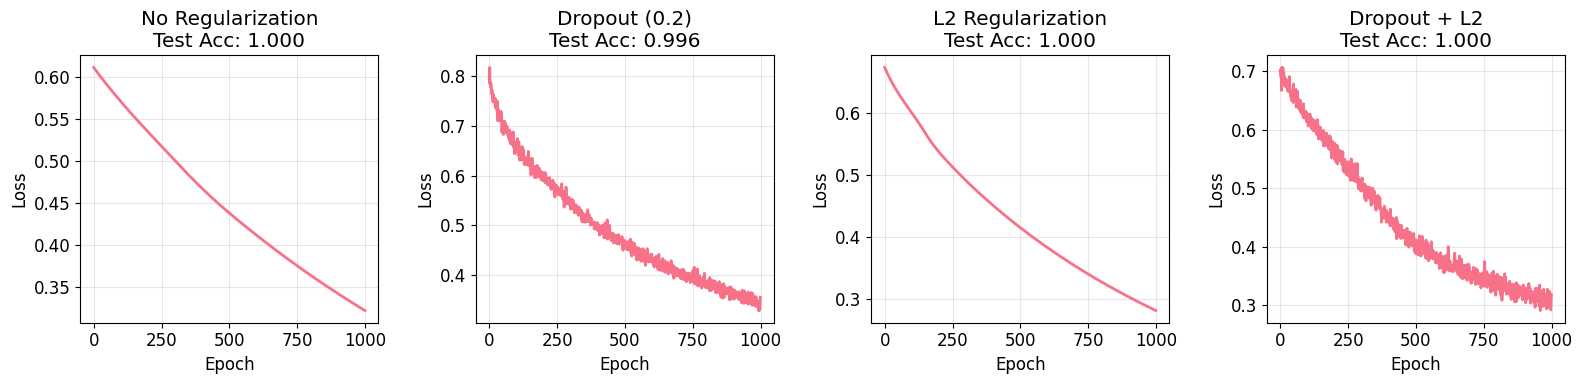


REGULARIZATION COMPARISON
Method               Train Acc    Test Acc     Overfitting 
--------------------------------------------------------------------------------
No Regularization    0.995        1.000        -0.005      
Dropout (0.2)        0.996        0.996        0.001       
L2 Regularization    0.998        1.000        -0.002      
Dropout + L2         0.998        1.000        -0.002      

🏆 Best regularization method: No Regularization


In [9]:
# Compare different regularization strategies
regularization_configs = [
    {'name': 'No Regularization', 'dropout_rate': 0.0, 'l2_lambda': 0.0},
    {'name': 'Dropout (0.2)', 'dropout_rate': 0.2, 'l2_lambda': 0.0},
    {'name': 'L2 Regularization', 'dropout_rate': 0.0, 'l2_lambda': 0.01},
    {'name': 'Dropout + L2', 'dropout_rate': 0.2, 'l2_lambda': 0.01}
]

regularization_results = {}

plt.figure(figsize=(16, 4))

for i, config in enumerate(regularization_configs):
    print(f"\nTraining: {config['name']}")
    
    # Create network with regularization
    reg_network = RegularizedNeuralNetwork(
        input_size=2, hidden_size=20, output_size=1, activation='relu',
        dropout_rate=config['dropout_rate'], l2_lambda=config['l2_lambda']
    )
    
    # Train the network
    losses = reg_network.train(X_train_c_scaled, y_train_c, epochs=1000, learning_rate=0.01)
    
    # Evaluate
    train_predictions = reg_network.predict(X_train_c_scaled)
    test_predictions = reg_network.predict(X_test_c_scaled)
    
    train_accuracy = np.mean(train_predictions == y_train_c)
    test_accuracy = np.mean(test_predictions == y_test_c)
    
    regularization_results[config['name']] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'losses': losses
    }
    
    # Plot loss curve
    plt.subplot(1, 4, i+1)
    plt.plot(losses, linewidth=2)
    plt.title(f"{config['name']}\nTest Acc: {test_accuracy:.3f}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results comparison
print("\n" + "="*80)
print("REGULARIZATION COMPARISON")
print("="*80)
print(f"{'Method':<20} {'Train Acc':<12} {'Test Acc':<12} {'Overfitting':<12}")
print("-"*80)

for method, result in regularization_results.items():
    overfitting = result['train_accuracy'] - result['test_accuracy']
    print(f"{method:<20} {result['train_accuracy']:<12.3f} {result['test_accuracy']:<12.3f} {overfitting:<12.3f}")

# Find best method (highest test accuracy)
best_method = max(regularization_results.keys(), 
                 key=lambda k: regularization_results[k]['test_accuracy'])
print(f"\n🏆 Best regularization method: {best_method}")

## Part 6: Model Evaluation and Visualization

Let's create a comprehensive evaluation of our best model.

Training final model...
Epoch 0, Loss: 0.9952


Epoch 100, Loss: 0.6770
Epoch 200, Loss: 0.5918
Epoch 300, Loss: 0.5202
Epoch 400, Loss: 0.4926
Epoch 500, Loss: 0.4552
Epoch 600, Loss: 0.4147
Epoch 700, Loss: 0.4068
Epoch 800, Loss: 0.3803
Epoch 900, Loss: 0.3457


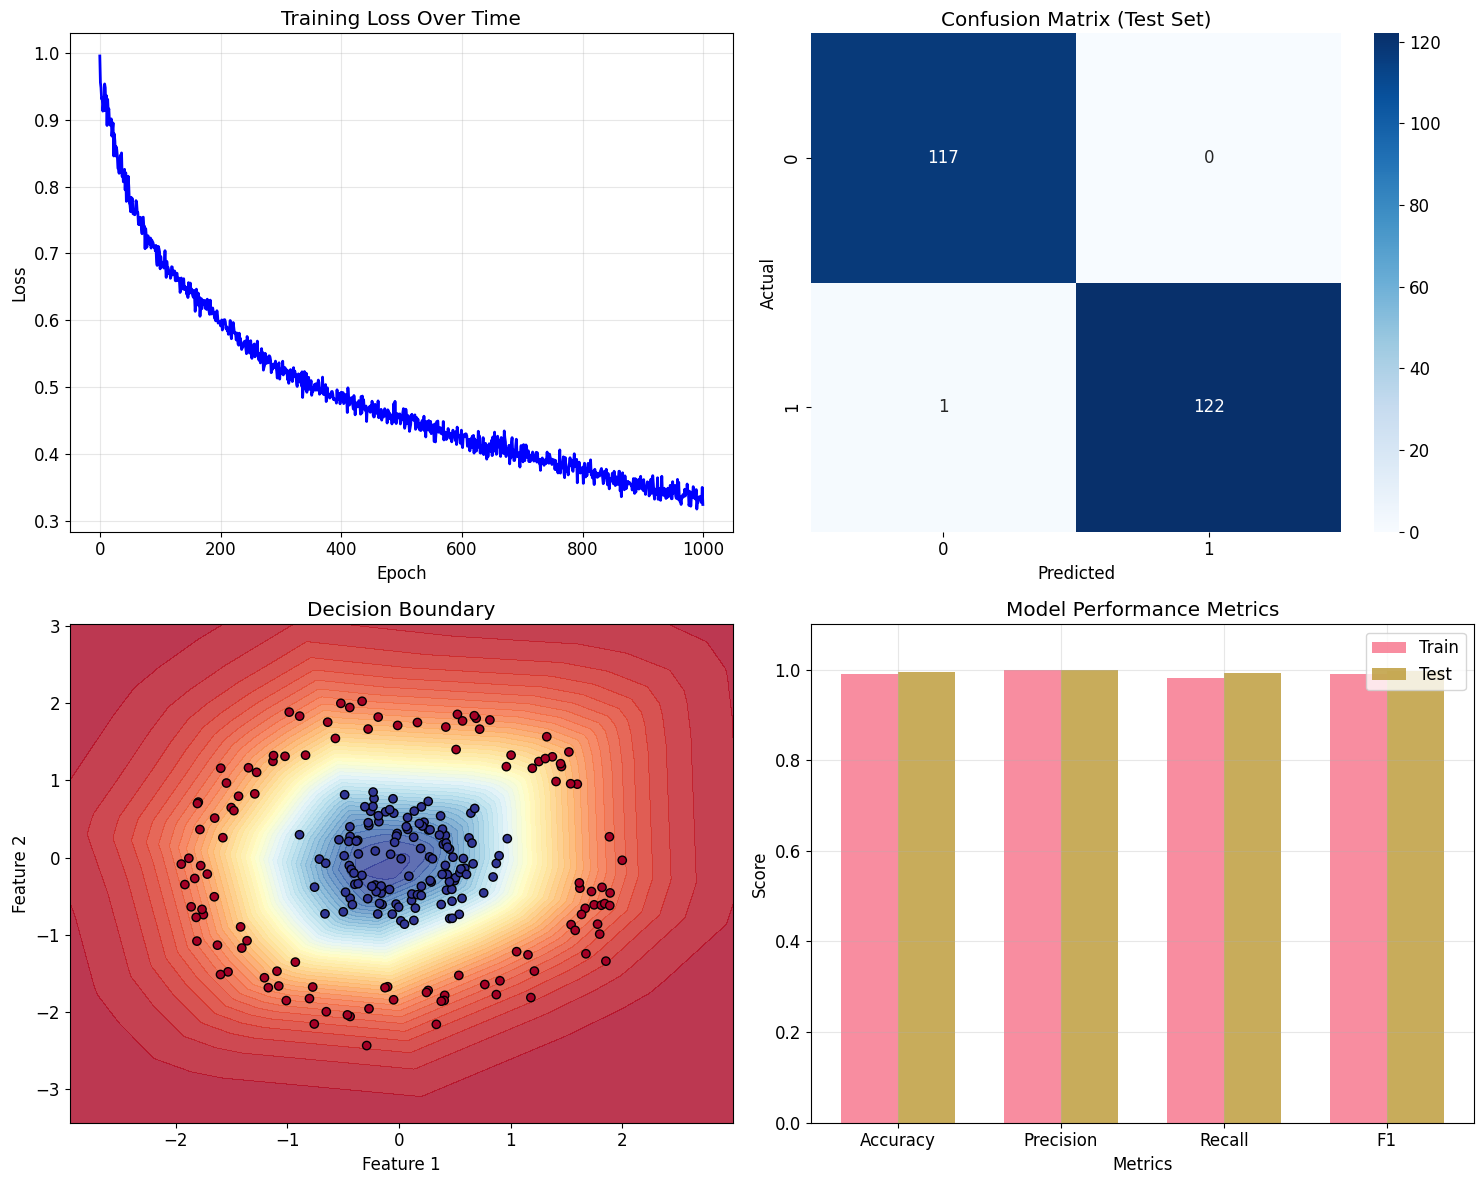


FINAL MODEL EVALUATION
Metric          Train      Test       Difference
------------------------------------------------------------
Accuracy        0.991      0.996      -0.005    
Precision       1.000      1.000      0.000     
Recall          0.982      0.992      -0.010    
F1              0.991      0.996      -0.005    

🎯 Final Test Accuracy: 99.6%
📊 Model Complexity: 60 parameters


In [10]:
# Train the best model for final evaluation
final_network = RegularizedNeuralNetwork(
    input_size=2, hidden_size=20, output_size=1, activation='relu',
    dropout_rate=0.2, l2_lambda=0.01
)

print("Training final model...")
final_losses = final_network.train(X_train_c_scaled, y_train_c, epochs=1000, learning_rate=0.01)

# Make predictions
train_pred = final_network.predict(X_train_c_scaled)
test_pred = final_network.predict(X_test_c_scaled)

# Calculate detailed metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_metrics = {
    'accuracy': accuracy_score(y_train_c, train_pred),
    'precision': precision_score(y_train_c, train_pred),
    'recall': recall_score(y_train_c, train_pred),
    'f1': f1_score(y_train_c, train_pred)
}

test_metrics = {
    'accuracy': accuracy_score(y_test_c, test_pred),
    'precision': precision_score(y_test_c, test_pred),
    'recall': recall_score(y_test_c, test_pred),
    'f1': f1_score(y_test_c, test_pred)
}

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Loss curve
axes[0, 0].plot(final_losses, 'b-', linewidth=2)
axes[0, 0].set_title('Training Loss Over Time')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_c, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix (Test Set)')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. Decision boundary visualization
def plot_decision_boundary(X, y, model, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.forward(grid_points, training=False)
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap='RdYlBu')
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='RdYlBu', edgecolors='black')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    return scatter

plot_decision_boundary(X_test_c_scaled, y_test_c, final_network, axes[1, 0], 'Decision Boundary')

# 4. Metrics comparison
metrics_names = list(train_metrics.keys())
train_values = list(train_metrics.values())
test_values = list(test_metrics.values())

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x - width/2, train_values, width, label='Train', alpha=0.8)
axes[1, 1].bar(x + width/2, test_values, width, label='Test', alpha=0.8)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Performance Metrics')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([m.capitalize() for m in metrics_names])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Print final evaluation
print("\n" + "="*60)
print("FINAL MODEL EVALUATION")
print("="*60)
print(f"{'Metric':<15} {'Train':<10} {'Test':<10} {'Difference':<10}")
print("-"*60)
for metric in metrics_names:
    diff = train_metrics[metric] - test_metrics[metric]
    print(f"{metric.capitalize():<15} {train_metrics[metric]:<10.3f} {test_metrics[metric]:<10.3f} {diff:<10.3f}")

print(f"\n🎯 Final Test Accuracy: {test_metrics['accuracy']:.1%}")
print(f"📊 Model Complexity: {final_network.W1.size + final_network.W2.size} parameters")

## Summary and Key Takeaways

### What We've Learned

1. **Neural Network Fundamentals**
   - Built a neural network from scratch
   - Implemented forward and backward propagation
   - Understood the role of activation functions

2. **Activation Functions**
   - Sigmoid: Good for binary classification output, but suffers from vanishing gradients
   - Tanh: Zero-centered, still has vanishing gradient issues
   - ReLU: Solves vanishing gradients, computationally efficient

3. **Regularization Techniques**
   - **Dropout**: Randomly sets neurons to zero during training
   - **L2 Regularization**: Penalizes large weights
   - Both help prevent overfitting

4. **Training Best Practices**
   - Always standardize your input features
   - Monitor both training and validation performance
   - Use appropriate learning rates
   - Implement regularization for complex models

### Next Steps
- Experiment with different architectures (more layers, different sizes)
- Try other optimization algorithms (Adam, RMSprop)
- Explore batch normalization
- Learn about convolutional neural networks for image data
- Study recurrent neural networks for sequence data

### 🚀 Challenge Problems
1. Implement batch normalization in the neural network
2. Add momentum to the gradient descent optimizer
3. Create a multi-class classification version (3+ classes)
4. Implement early stopping based on validation loss
5. Add learning rate scheduling

---
## Resources for Further Learning

### Books
- "Deep Learning" by Ian Goodfellow, Yoshua Bengio, and Aaron Courville
- "Pattern Recognition and Machine Learning" by Christopher Bishop
- "The Elements of Statistical Learning" by Hastie, Tibshirani, and Friedman

### Online Courses
- CS231n: Convolutional Neural Networks for Visual Recognition (Stanford)
- Deep Learning Specialization (Coursera)
- Fast.ai Practical Deep Learning for Coders

### Frameworks to Explore
- **TensorFlow/Keras**: Industry standard, great for production
- **PyTorch**: Popular in research, dynamic computation graphs
- **JAX**: Google's new framework, functional programming approach

---

**🎉 Congratulations! You've built and trained neural networks from scratch!**